# Geographical plots:

## Set-up:

### Imports:

In [26]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import os
from sklearn.decomposition import PCA
import matplotlib.collections as mcoll
import matplotlib.path as mpath

### Constants:

Constants for plots:

In [27]:
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Constants for data:

In [28]:
# Percentage of nearest neighbours:
PERC_NEIGH = 10
print(f'Percentage of nearest neighbours: {PERC_NEIGH/100}')

# Number of eigenmaps to compute:
NUM_EIGENVALUES = 20
print(f'Number of eigenmaps: {NUM_EIGENVALUES}')

# Path to input data:
INPUT_DATA = '../../../data/vandermeer/input_data/'
print(f'Path to input data: {INPUT_DATA}')

# Bandwitdh used for the heat kernel:
BDWTH = 'mean'
print(f'Bandwitdh used for the heat kernel: t_{BDWTH}')

USE_TAKENS = True
print(f'Using takens embedding: {USE_TAKENS}')

Percentage of nearest neighbours: 0.1
Number of eigenmaps: 20
Path to input data: ../../../data/vandermeer/input_data/
Bandwitdh used for the heat kernel: t_mean
Using takens embedding: True


### Load data: 

In [29]:
%%time
print('Reading input data:')
anomalies_cf = pd.read_csv(INPUT_DATA + 'anomalies_coefficients.csv', sep=',')
anomalies_cf = anomalies_cf.drop(['Unnamed: 0', 'Date'], axis=1)
raw_cf = pd.read_csv(INPUT_DATA + 'raw_data_coefficients.csv', sep=',')
raw_cf = raw_cf.drop(['Unnamed: 0', 'Date'], axis=1)
basis_cf = pd.read_csv(INPUT_DATA + 'basis_functions.csv', sep=',')
basis_array = np.array(basis_cf.drop(['Unnamed: 0', 'Lon', 'Lat'], axis=1))

print(f'Basis shape: {basis_array.shape}')
print(f'Raw data shape: {raw_cf.values.shape}')
print(f'Anomalies data shape: {anomalies_cf.values.shape}')

Reading input data:
Basis shape: (38400, 1001)
Raw data shape: (33960, 1001)
Anomalies data shape: (33960, 1001)
CPU times: user 21.3 s, sys: 1.24 s, total: 22.6 s
Wall time: 22.6 s


### Functions:

Function that creates a correct path depending on the type of data:

In [30]:
def path_to_data(DATA, PERC_NEIGH, BDWTH):
    if DATA == 'raw':
        PATH = '../../../data/vandermeer/pickles/raw/'
    elif DATA == 'anomalies': 
        PATH = '../../../data/vandermeer/pickles/anomalies/'
    if USE_TAKENS: 
        PATH1 = PATH + str(PERC_NEIGH)+f'perc/t_{BDWTH}/takens/'
    else: 
        PATH1 = PATH + str(PERC_NEIGH)+f'perc/t_{BDWTH}/'
    if not os.path.exists(PATH1):
            os.makedirs(PATH1)
    print(f'Precise path: {PATH1}')
    return PATH1

Function that applies basis transformation:

In [31]:
def basis_transf(coordinates, basis):
    """
    @input: 
    - basis np.array of shape (38400, 1001) or (1001, 38400)
    - coordinates np.array of shape (1001, )
    @output: geographical sample for one time step of shape np.array (38400,)
    """
    x = np.zeros(38400)
    if coordinates.shape == (1, 1001):
        coordinates = coordinates.T
    if basis.shape == (38400, 1001):
        basis = basis.T
    for i in range(len(coordinates)):
        x += coordinates[i] * basis[i]
    return x

Function that applies the basis transformation to a sample point, returns array of shape (lat, lon) and containing the PV values for each pair of coordinates. Necessary for plotting with cartopy

In [32]:
def create_geo_sample(sample_array, basis_array):
    """
    @input: 
    - basis np.array of shape (38400, 1001) or (1001, 38400)
    - coordinates np.array of shape (1001, )
    @output: 
    - values_array: array of shape (lat, lon) and containing the PV values for each pair of coordinates
    - lat: latitude coordinates
    - lon: longitude coordinates
    """
    X_sample = pd.DataFrame(
        data={
            'longitude': basis_cf['Lon'],
            'latitude': basis_cf['Lat'],
            'PV_values': basis_transf(sample_array, basis_array)
        })
    df = X_sample.pivot(index='latitude',
                                  columns='longitude',
                                  values='PV_values')
    values_array = df.values
    lat = df.index
    lon = df.columns.values
    return values_array, lat, lon

Functions to plot color segments in gradients:

In [33]:
def colorline(
    x, y, ax,z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    #ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

Function to plot regions on eigenvector vs eigenvector plots:

In [34]:
def plot_regions(ax,
                 regions,
                 sample_trajectories,
                 trajectories,
                 df,
                 alpha=0.8,
                 add_traj=True,
                 dates_=dates_,
                 colors_points=colors_points, labels_off = False):
    for i in range(len(regions)):
        if labels_off: 
            ax.plot(regions[i]['1'],
                    regions[i]['2'],
                    alpha=alpha,
                    linewidth=0.5,
                    color = 'darkgrey')
        else:
            ax.plot(regions[i]['1'],
                    regions[i]['2'],
                    alpha=alpha,
                    linewidth=0.5,
                    label=f'part {i+1}')
    if add_traj:
        """
        colorline(sample_trajectory[0],
                  sample_trajectory[1],
                  ax,
                  cmap=plt.get_cmap('winter_r'),
                  linewidth=2)
        """
        y = [1998, 2008, 2010]
        types = ['D+S', 'S', 'D']
        j = 0
        columns = df.columns
        # add special dates:
        for el in dates_[1:]:
            d_ = el[0]
            ax.plot(df[columns[0]][d_],
                    df[columns[1]][d_],
                    'x',
                    color=colors_points[el[1]])

        for sample_trajectory in sample_trajectories:
            line = ax.plot(np.real(sample_trajectory[0]),
                           np.real(sample_trajectory[1]),
                           linewidth=1,
                           color=colors_lines[types[j]],
                           label=f'{y[j]}-{y[j]+1}: {types[j]}')[0]
            j += 1
            add_arrow(line)

        # add special trajectories:
        for year in traj:
            if int(year) not in y and int(year) - 1 not in y:
                for el in traj[year]:
                    type_ = el[1]
                    winter_year_eig_0 = df[columns[0]][el[0]]
                    winter_year_eig_1 = df[columns[1]][el[0]]
                    line = ax.plot(winter_year_eig_0,
                                   winter_year_eig_1,
                                   linewidth=0.8,
                                   color=colors_points[type_],
                                   alpha=0.5)[0]
                    add_arrow(line, num_arrows=3, linewidth=0.8, alpha=0.5)

    ax.plot(df[columns[0]],
            df[columns[1]],
            linewidth=0.5,
            alpha=0.5,
            color='grey')

NameError: name 'dates_' is not defined

## PCA versus Eigenmaps:

### Raw: 

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

In [35]:
# PCA:
pca = PCA(n_components=NUM_EIGENVALUES)
pca.fit(np.array(raw_cf))

singular_values_pca = pca.singular_values_
explained_variance_ratio__pca = pca.explained_variance_ratio_
components_pca = pca.components_

print("Singular values: {sv} \nExplained variance: {ev}".format(
    sv=singular_values_pca, ev=explained_variance_ratio__pca))

Singular values: [0.01351784 0.00915538 0.00739242 0.00563988 0.00541272 0.00479449
 0.00367113 0.00342344 0.00323525 0.0031639  0.00294812 0.0025928
 0.00243065 0.00231127 0.00225143 0.00220725 0.00199379 0.00196006
 0.00187616 0.00184042] 
Explained variance: [0.30223216 0.13863696 0.09038559 0.05260966 0.04845708 0.03801986
 0.02229081 0.01938435 0.01731174 0.01655662 0.01437526 0.01111898
 0.00977171 0.0088354  0.00838385 0.00805806 0.00657481 0.00635428
 0.00582192 0.00560219]


In [36]:
def plot_eigenvalues(w_mean,explained_variance,stop, NUM_EIGENVALUES):
    fig, axs = plt.subplots(1, figsize=(10, 5))
    axs.scatter(x=range(0, NUM_EIGENVALUES),
                y=w_mean,
                marker='o',
                alpha=0.7)
    #axs.set_title(f'Eigenvalues for heat and simple kernel')
    axs.set_ylabel('Singular value')
    axs.set_xlabel('Number of singular value')
    
    x =range(0, NUM_EIGENVALUES)
    y = w_mean
    n = []
    for i in explained_variance:
        n.append(f"{round(i*100,2)}%")
    for i, txt in enumerate(n):
        if i < stop:
            axs.annotate(txt, (x[i], y[i]))
    plt.locator_params(axis='x', nbins=21)

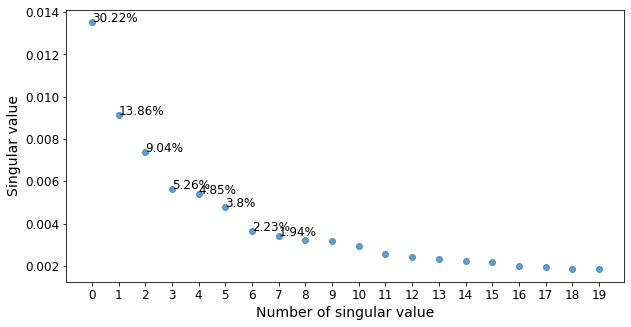

In [37]:
plot_eigenvalues(singular_values_pca,explained_variance_ratio__pca,8,NUM_EIGENVALUES)

In [38]:
def multiplot_PCA_eigenmap(components_pca,
                           basis_array,
                           sign_PCA,
                           sign_eigenmap,
                           explained_variance_ratio__pca,
                           m=0,
                           n=0,
                           DATA='raw',
                           PERC_NEIGH=10,
                           BDWTH='mean',
                           NUM_EIGENVALUES=20):

    PATH1 = path_to_data(DATA, PERC_NEIGH, BDWTH)
    eigenvectors = np.zeros((NUM_EIGENVALUES, 1001))

    for i in range(NUM_EIGENVALUES):
        if USE_TAKENS:
            X_prime_i = np.load(PATH1 + f'X_prime_{i}_takens_.npy')
        else:
            X_prime_i = np.load(PATH1 + f'X_prime_{i}.npy')
        eigenvectors[i] = np.real(X_prime_i)

    projection = ccrs.Orthographic(central_longitude=0.0,
                                   central_latitude=90.0)
    data_crs = ccrs.PlateCarree()

    fig = plt.figure(figsize=(15, 15))

    for i in range(1, 21):
        if i <= 5:
            values_array, lat, lon = create_geo_sample(
                np.multiply(components_pca[m], 1e6), basis_array)
            axi = plt.subplot(4, 5, i, projection=projection)
            expl_var = round(explained_variance_ratio__pca[m]*100,2)
            plt.title('EOF {} ({}%)'.format(m + 1, expl_var))
            axi.set_global()
            axi.coastlines()
            pcm = axi.contourf(lon,
                               lat,
                               sign_PCA[m] * values_array,
                               60,
                               transform=data_crs,
                               cmap='RdYlBu_r')
            m += 1
        if 5 < i and i <= 10:
            values_array, lat, lon = create_geo_sample(
                np.multiply(eigenvectors[n], 1e6), basis_array)
            axi = plt.subplot(4, 5, i, projection=projection)
            plt.title('NLSA eigenmap {}'.format(n + 1))
            axi.set_global()
            axi.coastlines()
            pcm = axi.contourf(lon,
                               lat,
                               sign_eigenmap[n] * values_array,
                               60,
                               transform=data_crs,
                               cmap='RdYlBu_r')
            n += 1
        if 10 < i and i <= 15:
            values_array, lat, lon = create_geo_sample(
                np.multiply(components_pca[m], 1e6), basis_array)
            axi = plt.subplot(4, 5, i, projection=projection)
            expl_var = round(explained_variance_ratio__pca[m]*100,2)
            plt.title('EOF {} ({}%)'.format(m + 1, expl_var))
            axi.set_global()
            axi.coastlines()
            pcm = axi.contourf(lon,
                               lat,
                               sign_PCA[m] * values_array,
                               60,
                               transform=data_crs,
                               cmap='RdYlBu_r')
            m += 1
        if 15 < i:
            values_array, lat, lon = create_geo_sample(
                np.multiply(eigenvectors[n], 1e6), basis_array)
            axi = plt.subplot(4, 5, i, projection=projection)
            plt.title('NLSA eigenmap {}'.format(n + 1))
            axi.set_global()
            axi.coastlines()
            pcm = axi.contourf(lon,
                               lat,
                               sign_eigenmap[n] * values_array,
                               60,
                               transform=data_crs,
                               cmap='RdYlBu_r')
            n += 1
    plt.show()

In [39]:
def multiplot_PCA_eigenmap_(components_pca,
                           basis_array,
                           sign_PCA,
                           sign_eigenmap,sign_eigenmap_takens,
                           explained_variance_ratio__pca,
                           m=0,
                           n=0, j = 0,
                           DATA='raw',
                           PERC_NEIGH=10,
                           BDWTH='mean',
                           NUM_EIGENVALUES=20):

    PATH1 = path_to_data(DATA, PERC_NEIGH, BDWTH)
    eigenvectors = np.zeros((NUM_EIGENVALUES, 1001))
    eigenvectors_takens = np.zeros((NUM_EIGENVALUES, 1001))

    for i in range(NUM_EIGENVALUES):
        PATH = f'../../../data/vandermeer/pickles/{DATA}/10perc/t_mean/'
        X_prime_i_takens = np.load(PATH1 + f'X_prime_{i}_takens_.npy')
        X_prime_i = np.load(PATH + f'X_prime_{i}.npy')
        eigenvectors[i] = np.real(X_prime_i)
        eigenvectors_takens[i] = np.real(X_prime_i_takens)

    projection = ccrs.Orthographic(central_longitude=0.0,
                                   central_latitude=90.0)
    data_crs = ccrs.PlateCarree()

    fig = plt.figure(figsize=(15, 15))

    for i in range(1, 16):
        if i <= 5:
            values_array, lat, lon = create_geo_sample(
                np.multiply(components_pca[m], 1e6), basis_array)
            axi = plt.subplot(4, 5, i, projection=projection)
            expl_var = round(explained_variance_ratio__pca[m]*100,2)
            plt.title('EOF {} ({}%)'.format(m + 1, expl_var))
            axi.set_global()
            axi.coastlines()
            pcm = axi.contourf(lon,
                               lat,
                               sign_PCA[m] * values_array,
                               60,
                               transform=data_crs,
                               cmap='RdYlBu_r')
            m += 1
        if 5 < i and i <= 10:
            values_array, lat, lon = create_geo_sample(
                np.multiply(eigenvectors[n], 1e6), basis_array)
            axi = plt.subplot(4, 5, i, projection=projection)
            plt.title('Eigenmap {}'.format(n + 1))
            axi.set_global()
            axi.coastlines()
            pcm = axi.contourf(lon,
                               lat,
                               sign_eigenmap[n] * values_array,
                               60,
                               transform=data_crs,
                               cmap='RdYlBu_r')
            n += 1
        if 10 < i and i <= 15:
            values_array, lat, lon = create_geo_sample(
                np.multiply(eigenvectors_takens[j], 1e6), basis_array)
            axi = plt.subplot(4, 5, i, projection=projection)
            plt.title('NLSA eigenmap {}'.format(j + 1))
            axi.set_global()
            axi.coastlines()
            pcm = axi.contourf(lon,
                               lat,
                               sign_eigenmap_takens[j] * values_array,
                               60,
                               transform=data_crs,
                               cmap='RdYlBu_r')
            j += 1
    plt.show()

Precise path: ../../../data/vandermeer/pickles/raw/10perc/t_mean/takens/


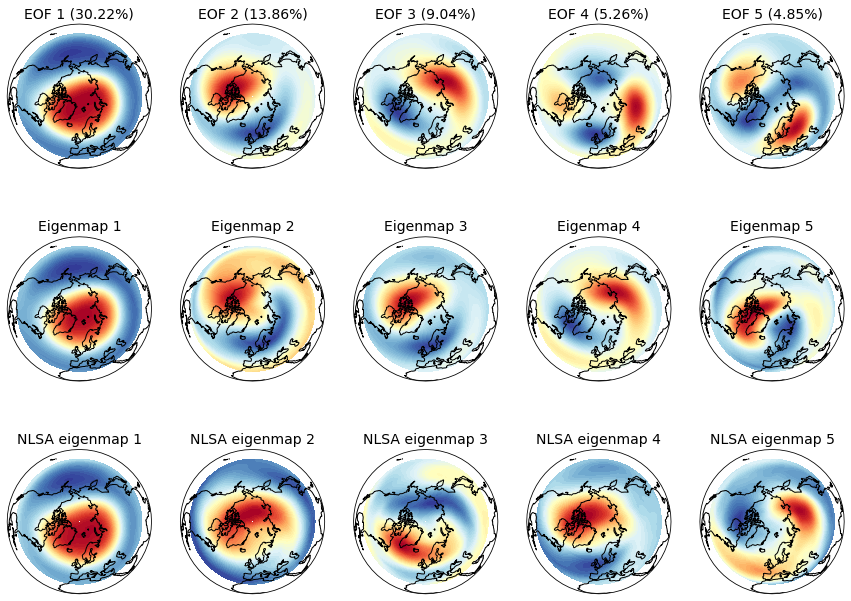

In [40]:
sign_PCA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
sign_eigenmap = [-1, -1, -1, -1, -1, -1, -1, -1, 1, -1]
sign_eigenmap_takens = [1, 1, -1, 1, 1, 1, -1, -1, 1, -1]

m, n, j = 0, 0, 0
multiplot_PCA_eigenmap_(components_pca,
                        basis_array,
                        sign_PCA,
                        sign_eigenmap,
                        sign_eigenmap_takens,
                        explained_variance_ratio__pca,
                        m,
                        n,
                        j,
                        DATA='raw',
                        PERC_NEIGH=10,
                        BDWTH='mean',
                        NUM_EIGENVALUES=20)

Precise path: ../../../data/vandermeer/pickles/raw/10perc/t_mean/takens/


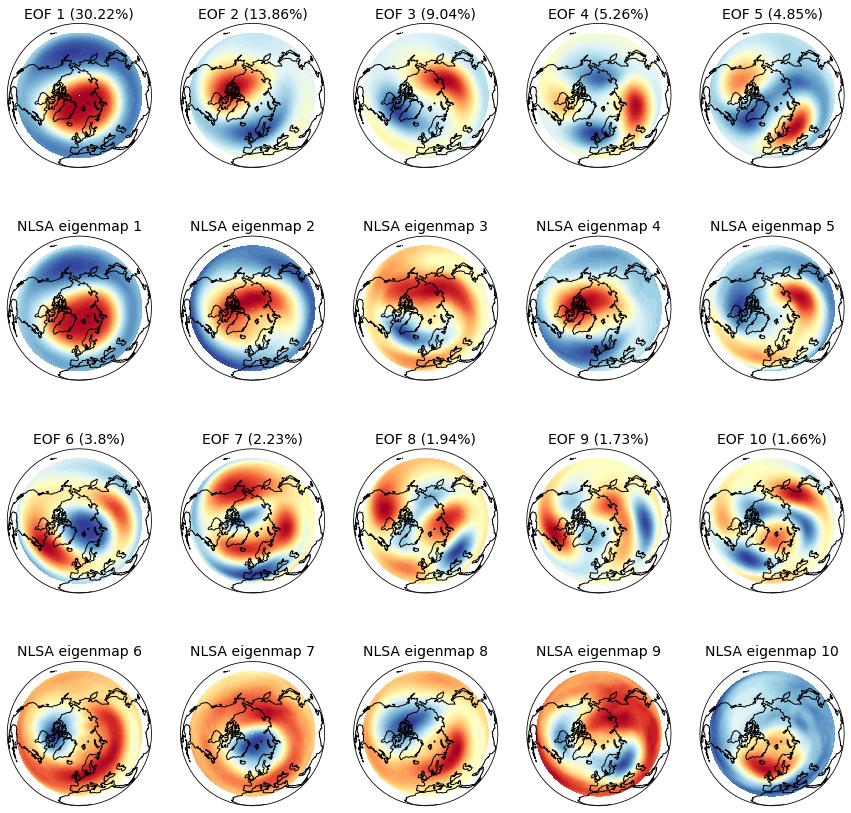

In [41]:
if USE_TAKENS:
    sign_PCA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    sign_eigenmap = [1, 1, 1, 1, 1, 1, -1, -1, 1, -1]
else:
    sign_PCA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    sign_eigenmap = [-1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
m,n = 0,0
multiplot_PCA_eigenmap(components_pca,
                       basis_array,sign_PCA, sign_eigenmap,explained_variance_ratio__pca,m,n,
                       DATA='raw',
                       PERC_NEIGH=10,
                       BDWTH='mean',
                       NUM_EIGENVALUES=20)

Precise path: ../../../data/vandermeer/pickles/raw/10perc/t_mean/takens/


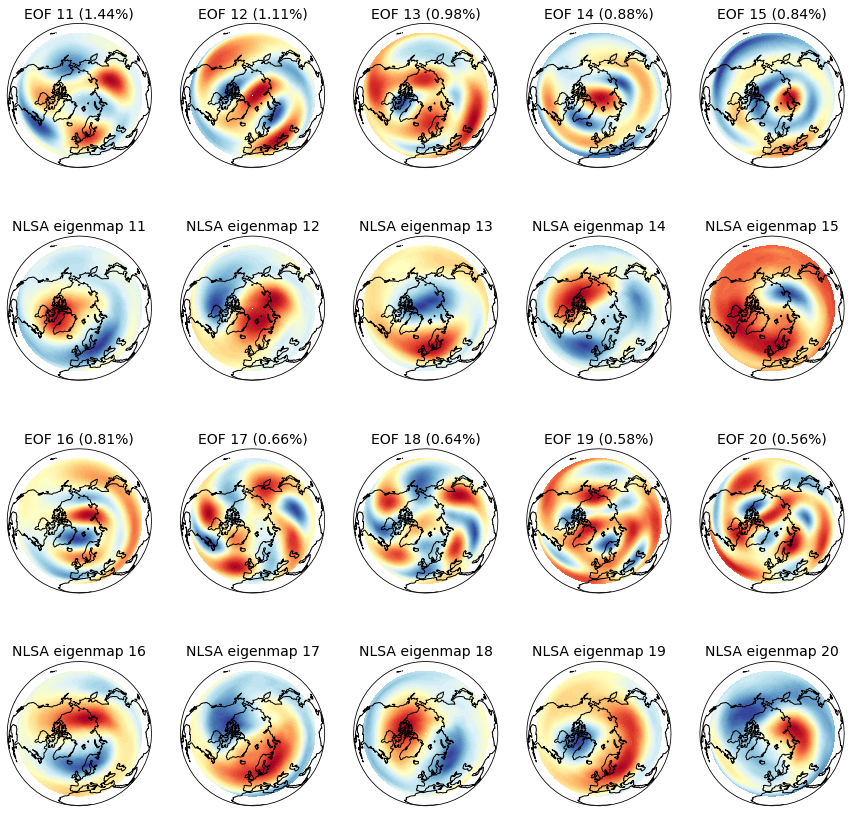

In [42]:
if USE_TAKENS:
    sign_PCA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    sign_eigenmap = [-1, -1, 1, 1, 1, 1, 1, 1, -1, 1,-1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
else:
    sign_PCA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    sign_eigenmap = [-1, -1, -1, -1, -1, -1, 1, -1, -1, -1,-1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
m,n = 10, 10
multiplot_PCA_eigenmap(components_pca,
                       basis_array,sign_PCA, sign_eigenmap,explained_variance_ratio__pca,m,n,
                       DATA='raw',
                       PERC_NEIGH=10,
                       BDWTH='mean',
                       NUM_EIGENVALUES=20)

Precise path: ../../../data/vandermeer/pickles/raw/10perc/t_mean/takens/


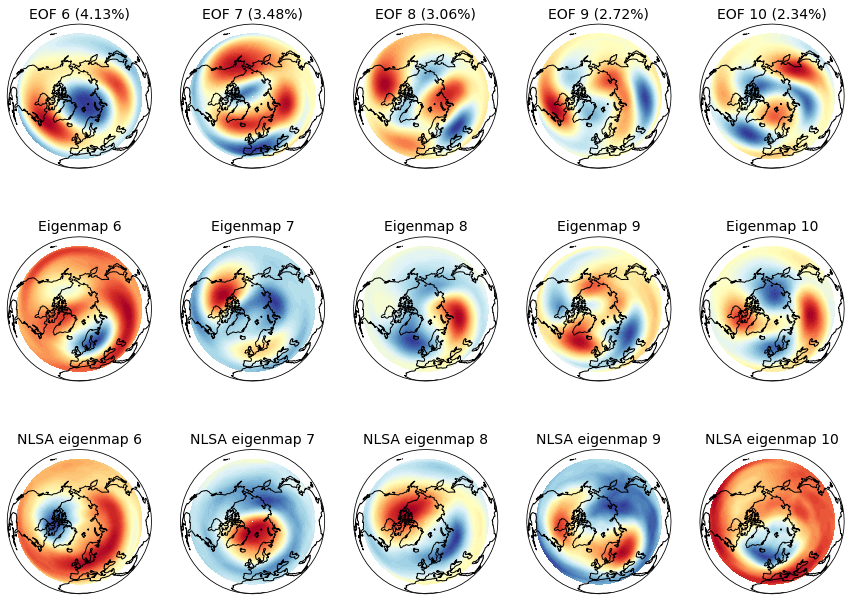

In [49]:
sign_PCA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
sign_eigenmap = [-1, -1, 1, 1, 1, 1, 1, 1, -1, 1,-1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
sign_eigenmap_takens = [-1, -1, 1, 1, 1, 1, 1, 1, -1, 1,-1, -1, -1, -1, -1, -1, 1, -1, -1, -1]

m, n, j = 5, 5,5
multiplot_PCA_eigenmap_(components_pca,
                        basis_array,
                        sign_PCA,
                        sign_eigenmap,
                        sign_eigenmap_takens,
                        explained_variance_ratio__pca,
                        m,
                        n,
                        j,
                        DATA='raw',
                        PERC_NEIGH=10,
                        BDWTH='mean',
                        NUM_EIGENVALUES=20)

### Anomalies: 

In [44]:
# PCA:
pca = PCA(n_components=NUM_EIGENVALUES)
pca.fit(np.array(anomalies_cf))

singular_values_pca_an = pca.singular_values_
explained_variance_ratio__pca = pca.explained_variance_ratio_
components_pca_an = pca.components_

print("Singular values: {sv} \nExplained variance: {ev}".format(
    sv=singular_values_pca, ev=explained_variance_ratio__pca))

Singular values: [0.01351784 0.00915538 0.00739242 0.00563988 0.00541272 0.00479449
 0.00367113 0.00342344 0.00323525 0.0031639  0.00294812 0.0025928
 0.00243065 0.00231127 0.00225143 0.00220725 0.00199379 0.00196006
 0.00187616 0.00184042] 
Explained variance: [0.11793901 0.10424032 0.07995019 0.06031895 0.05119158 0.04125194
 0.03483436 0.03063228 0.02724685 0.0233668  0.02162972 0.01779005
 0.01733542 0.01486514 0.0146731  0.0142742  0.01248719 0.01069176
 0.0101346  0.00987749]


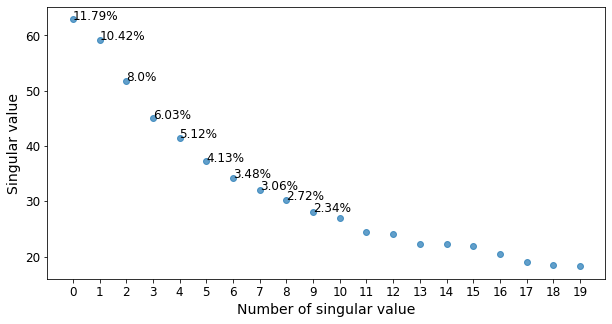

In [45]:
plot_eigenvalues(singular_values_pca_an,explained_variance_ratio__pca,10,NUM_EIGENVALUES)

Precise path: ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/takens/


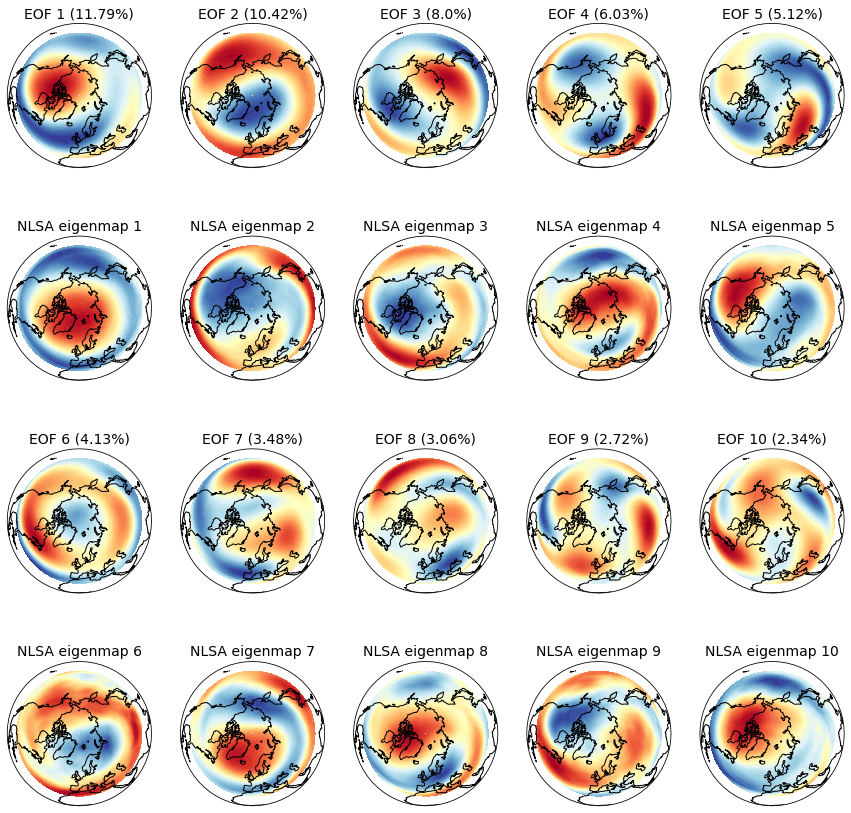

In [46]:
sign_PCA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
sign_eigenmap = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
m,n = 0,0
multiplot_PCA_eigenmap(components_pca_an,
                       basis_array,sign_PCA, sign_eigenmap,explained_variance_ratio__pca,m,n,
                       DATA='anomalies',
                       PERC_NEIGH=10,
                       BDWTH='mean',
                       NUM_EIGENVALUES=20)

Precise path: ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/takens/


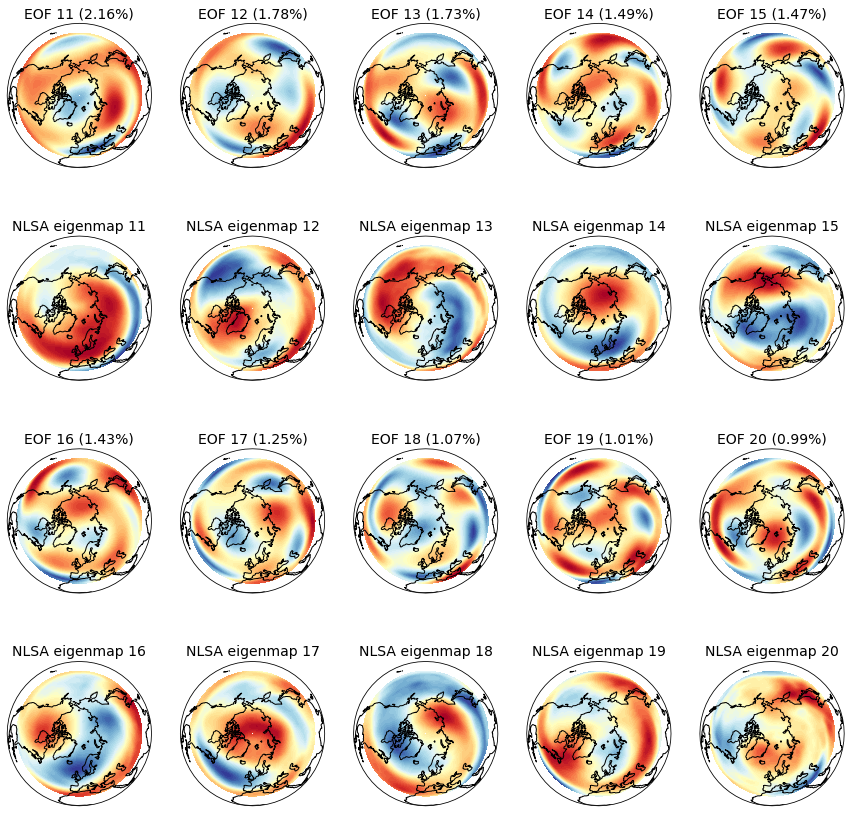

In [47]:
sign_PCA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
sign_eigenmap = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
m, n = 10, 10
multiplot_PCA_eigenmap(components_pca_an,
                       basis_array,
                       sign_PCA,
                       sign_eigenmap,
                       explained_variance_ratio__pca,
                       m,
                       n,
                       DATA='anomalies',
                       PERC_NEIGH=10,
                       BDWTH='mean',
                       NUM_EIGENVALUES=20)

Precise path: ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/takens/


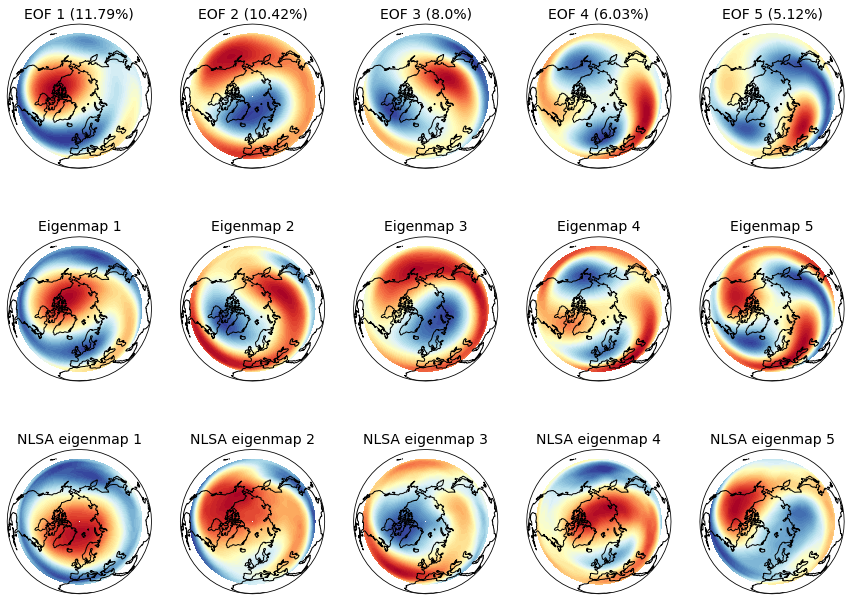

In [50]:
sign_PCA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
sign_eigenmap = [1, 1, 1, 1, 1, 1, -1, -1, 1, -1]
sign_eigenmap_takens = [1, -1, 1, 1, 1, 1, -1, -1, 1, -1]

m, n, j = 0, 0, 0
multiplot_PCA_eigenmap_(components_pca_an,
                        basis_array,
                        sign_PCA,
                        sign_eigenmap,
                        sign_eigenmap_takens,
                        explained_variance_ratio__pca,
                        m,
                        n,
                        j,
                        DATA='anomalies',
                        PERC_NEIGH=10,
                        BDWTH='mean',
                        NUM_EIGENVALUES=20)

Precise path: ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/takens/


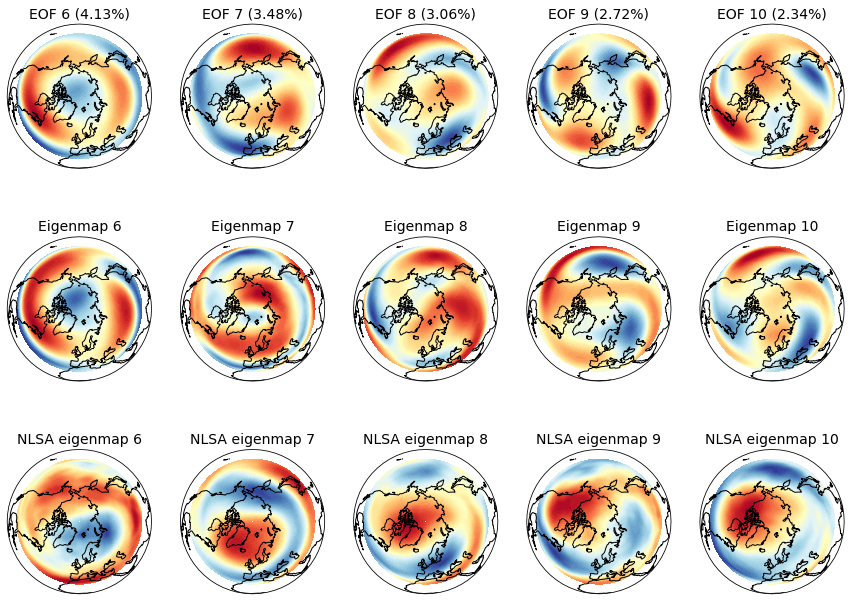

In [51]:
sign_PCA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
sign_eigenmap = [-1, -1, 1, 1, 1, 1, 1, 1, -1, 1,-1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
sign_eigenmap_takens = [-1, -1, 1, 1, 1, 1, 1, 1, -1, 1,-1, -1, -1, -1, -1, -1, 1, -1, -1, -1]

m, n, j = 5, 5,5
multiplot_PCA_eigenmap_(components_pca_an,
                        basis_array,
                        sign_PCA,
                        sign_eigenmap,
                        sign_eigenmap_takens,
                        explained_variance_ratio__pca,
                        m,
                        n,
                        j,
                        DATA='anomalies',
                        PERC_NEIGH=10,
                        BDWTH='mean',
                        NUM_EIGENVALUES=20)

## Average patterns:

In [ ]:
from dateutil.relativedelta import relativedelta

dates = [['1980-02-29-12:00:00', 'D'],
         ['1981-03-04-12:00:00', 'D'], ['1981-12-04-12:00:00', 'D'],
         ['1984-02-24-12:00:00', 'D'], ['1985-01-01-12:00:00', 'S'],
         ['1987-01-23-12:00:00', 'D'], ['1987-12-08-12:00:00', 'S'],
         ['1988-03-14-12:00:00', 'S'], ['1989-02-21-12:00:00', 'S'],
         ['1998-12-15-12:00:00', 'D'], ['1999-02-26-12:00:00', 'S'],
         ['2000-03-20-12:00:00', 'D'], ['2001-02-11-12:00:00', 'S'],
         ['2001-12-30-12:00:00', 'D'], ['2003-01-18-12:00:00', 'S'],
         ['2004-01-05-12:00:00', 'D'], ['2006-01-21-12:00:00', 'D'],
         ['2007-02-24-12:00:00', 'D'], ['2008-02-22-12:00:00', 'D'],
         ['2009-01-24-12:00:00', 'S'], ['2010-02-09-12:00:00', 'S'],
         ['2013-01-07-12:00:00', 'S']]

dates_ = []
for el in dates:
    year = str(pd.to_datetime(el[0]).year)
    two_months = [
        str(pd.to_datetime(el[0]) + relativedelta(months=2)), el[1] + '_TM'
    ]
    dates_.append(el)
    if (pd.to_datetime(el[0]) + relativedelta(months=2)).month < 4 and (
            pd.to_datetime(el[0]) + relativedelta(months=2)).month >= 1:
        dates_.append(two_months)
    if (pd.to_datetime(el[0]) + relativedelta(months=2)).month >= 10:
        dates_.append(two_months)

In [ ]:
years_in_d = {}
for el in dates_:
    year = str(pd.to_datetime(el[0]).year)
    if year not in years_in_d:
        years_in_d[year] = [[el[0], el[1]]]
    else:
        l = [j for j in years_in_d[year]]
        l.append([el[0], el[1]])
        years_in_d[year] = l
years_in_d

In [ ]:
# two month trajectories:
trajectories = []
for el in dates:
    year = str(pd.to_datetime(el[0]).year)
    two_months = [str(pd.to_datetime(el[0]) + relativedelta(months=2)), el[1] + '_TM']
    
    if pd.to_datetime(el[0]).month < 4:
        if (pd.to_datetime(el[0]) + relativedelta(months=2)).month < 4:
            trajectories.append([el, two_months])
        else:
            end_of_month = [f'{year}-03-31-12:00:00', el[1] + '_TM']
            trajectories.append([el, end_of_month])           
    else: 
        trajectories.append([el, two_months])
        
traj = {}
for el in trajectories:
    start = el[0]
    end = el[1]
    year = str(pd.to_datetime(start[0]).year)
    range_ = pd.date_range(str(pd.to_datetime(start[0]).year) + '-' +
                               str(pd.to_datetime(start[0]).month) + '-' +
                               str(pd.to_datetime(start[0]).day),
                               str(pd.to_datetime(end[0]).year) + '-' +
                               str(pd.to_datetime(end[0]).month) + '-' +
                               str(pd.to_datetime(end[0]).day),
                               freq='6H')
    type_ = el[0][1]
    if year not in traj:
        traj[year] = [[range_, type_]]
    else:
        l = [j for j in traj[year]]
        l.append([range_, type_])
        traj[year] = l
traj

In [ ]:
colors_lines ={'S':'darkblue', 'D':'darkred', 'D+S':'darkorange'}
colors_points = {
    'D': 'purple',
    'D_TM': 'darkred',
    'S': 'deepskyblue',
    'S_TM': 'darkblue'
}

In [ ]:
def add_arrow(line, position=None, direction='right', size=15, color=None, num_arrows = 5,linewidth=1, alpha=1):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    min_ = xdata.min()
    max_ = xdata.max()
    if position is None:
        positions = np.linspace(min_, max_, num_arrows)
    # find closest index
    start_inds = [np.argmin(np.absolute(xdata - p)) for p in positions]
    if direction == 'right':
        end_inds = [start_ind + 1 for start_ind in start_inds]
    else:
        end_inds = [start_ind - 1 for start_ind in start_inds]
    for i in range(len(start_inds)):
        if start_inds[i] < len(xdata) and end_inds[i] < len(xdata): 
            line.axes.annotate('',
                               xytext=(xdata[start_inds[i]], ydata[start_inds[i]]),
                               xy=(xdata[end_inds[i]], ydata[end_inds[i]]),
                               arrowprops=dict(arrowstyle="->", color=color, linewidth=linewidth, alpha=alpha),
                               size=size)

### NLSA: 

In [ ]:
PATH_TAKENS = '../../../data/vandermeer/pickles/raw/10perc/takens/'
patterns= pd.read_csv(PATH_TAKENS+'pattern_eig1_eig2.csv').drop(['Unnamed: 0'], axis = 1)
patterns.head()

In [ ]:
## first day from pattern e.g., first 150 coefficients:
coefs_day_1 = patterns.values[0,:150]
coefs_day_1

In [ ]:
from tqdm import tqdm
import imageio

# Number of different patterns:
N = int(patterns.shape[1] / 150)
print(f'Number of patterns: {N}')

# For each of the geographical parts calculate average projection over N days:
values, latitudes, longitudes = [], [], []

for i in range(len(patterns)):
    part = patterns.iloc[i]
    # Calculate geoprojections with basis coefficients for each day
    average_pattern = np.zeros((N, 150))
    for i in range(N):
        coefs_day_i = part[i * 150:150 * (i + 1)].values
        average_pattern[i, :] = coefs_day_i.T

    average_pattern = np.mean(average_pattern, axis=0)

    # transform to geographical projections:
    values_array, lat, lon = create_geo_sample(average_pattern, basis_array)
    values.append(values_array)
    latitudes.append(lat)
    longitudes.append(lon)

vmin = np.min(np.array(values))
vmax = np.max(np.array(values))
print(f'Min and max values {vmin},{vmax}')

In [ ]:
len(values), len(latitudes), len(longitudes)

In [ ]:
# Create the gif:
if not os.path.exists('gif/'):
    os.makedirs('gif/')
    
if not os.path.exists('gif/gifs/'):
    os.makedirs('gif/gifs/')

fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(111, projection=projection)
ax1.set_global()
ax1.coastlines()

for i in tqdm(range(len(values))):
    lon, lat, values_array = longitudes[i], latitudes[i], values[i]
    ax1.contourf(lon,
                 lat,
                 values_array,
                 60,
                 transform=data_crs,
                 cmap='RdYlBu_r',
                 vmin=vmin,
                 vmax=vmax,
                 extend='max')
    plt.savefig(f'gif/image{i}.png')

images = []
filenames = []
for i in range(len(values)):
    filenames.append(f'gif/image{i}.png')
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('gif/gifs/raweig1vs2_nlsa_takens.gif', images, duration=0.25)

#### Raw 1 vs 2: 

In [ ]:
PATH1 = path_to_data('raw', PERC_NEIGH, BDWTH)
PATH_TAKENS = '../../../data/vandermeer/pickles/raw/10perc/takens/'
eig_1 = -np.load(PATH1 + 'eignpy_1_takens_.npy')
eig_2 = np.load(PATH1 + 'eignpy_2_takens_.npy')
winter_2008_eig_1 = -np.load(PATH1 + 'winter_eignpy_1_takens_2008.npy')
winter_2008_eig_2 = np.load(PATH1 + 'winter_eignpy_2_takens_2008.npy')
winter_2010_eig_1 = -np.load(PATH1 + 'winter_eignpy_1_takens_2010.npy')
winter_2010_eig_2 = np.load(PATH1 + 'winter_eignpy_2_takens_2010.npy')
winter_1998_eig_1 = -np.load(PATH1 + 'winter_eignpy_1_takens_1998.npy')
winter_1998_eig_2 = np.load(PATH1 + 'winter_eignpy_2_takens_1998.npy')
raw_cf = pd.read_csv(INPUT_DATA + 'raw_data_coefficients.csv', sep=',')

In [ ]:
time_nlsa= pd.read_csv(PATH_TAKENS+'time_nlsa.csv')
time_nlsa['Date'] = pd.to_datetime(time_nlsa['Date'])
time_nlsa = time_nlsa.drop('Unnamed: 0', axis = 1)

In [ ]:
df = pd.DataFrame(data = {'1': np.real(eig_1), '2': np.real(eig_2)}, index = time_nlsa['Date'])

In [ ]:
part1 = df[df['2'] >= 0.0001]
part1 = part1[part1['1'].between(-0.0002, -0.0001)]

part2 = df[df['1'].between(-0.0002, -0.0001)]
part2 = part2[part2['2'].between(-0.0001, 0.0)]

part3 = df[df['1'].between(-0.0002, -0.0001)]
part3 = part3[part3['2'].between(-0.0005, -0.0002)]

part4 = df[df['1'].between(-0.00005, 0.00005)]
part4 = part4[part4['2'].between(-0.0005, -0.0003)]

part5 = df[df['2'].between(-0.0004, -0.0003)]
part5 = part5[part5['1'].between(0.0001, 0.0003)]

part6 = df[df['1'].between(0.0001, 0.0003)]
part6 = part6[part6['2'].between(-0.0001, 0.0)]

part7 = df[df['1'].between(0.0001, 0.0003)]
part7 = part7[part7['2'].between(0.0001, 0.0003)]

part8 = df[df['1'].between(-0.00005, 0.00005)]
part8 = part8[part8['2'].between(0.0001, 0.0002)]

regions = [part1, part2, part3, part4, part5, part6,part7, part8]

In [ ]:
def plot_regions(ax, regions, sample_trajectories,trajectories, df, alpha = 0.8, add_traj = True, 
                 colors_lines = colors_lines, dates_ = dates_, colors_points = colors_points):
    for i in range(len(regions)):
        ax.plot(regions[i]['1'],
                regions[i]['2'],alpha = alpha,
                linewidth=0.5,
                label=f'part {i+1}')
    if add_traj:
        """
        colorline(sample_trajectory[0],
                  sample_trajectory[1],
                  ax,
                  cmap=plt.get_cmap('winter_r'),
                  linewidth=2)
        """
        y = [1998, 2008, 2010]
        types = ['D+S', 'S', 'D']
        j = 0
        columns = df.columns
        # add special dates: 
        for el in dates_[1:]:
            d_ = el[0]
            ax.plot(df[columns[0]][d_],df[columns[1]][d_],
                                   'x',
                                   color=colors_points[el[1]])
        
        for sample_trajectory in sample_trajectories:
            line = ax.plot(np.real(sample_trajectory[0]),
                                              np.real(sample_trajectory[1]),
                                              linewidth=1,
                                              color=colors_lines[types[j]],
                                              label=f'{y[j]}-{y[j]+1}: {types[j]}')[0]
            j+=1
            add_arrow(line)

        # add special trajectories: 
        for year in traj:
            if int(year) not in y and int(year)-1 not in y:
                for el in traj[year]:
                    type_ = el[1]
                    winter_year_eig_0 = df[columns[0]][el[0]]
                    winter_year_eig_1 = df[columns[1]][el[0]]
                    line = ax.plot(winter_year_eig_0, winter_year_eig_1,
                                                  linewidth=0.8,
                                                  color=colors_points[type_], alpha = 0.5)[0]
                    add_arrow(line, num_arrows = 3,linewidth=0.8, alpha = 0.5)
                    
    ax.plot(df[columns[0]], df[columns[1]],linewidth=0.5,alpha=0.5,color='grey')

In [ ]:
sample_trajectories = [[winter_1998_eig_1, winter_1998_eig_2],
                       [winter_2008_eig_1, winter_2008_eig_2],
                       [winter_2010_eig_1, winter_2010_eig_2]]
eigs = [np.real(eig_1), np.real(eig_2)]
fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot(1, 1, 1)
plot_regions(ax1,
             regions,
             sample_trajectories=sample_trajectories,
             df=df,
             trajectories=traj,
             alpha=1,
             colors_lines=colors_lines,
             dates_=dates_,
             colors_points=colors_points, labels_off = True)
plt.title('Eig 1 VS 2 with filtered regions:')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
times = [filt_part.index for filt_part in regions]
time = raw_cf['Date']
time = pd.to_datetime(time)
df_mean = raw_cf.drop(['Unnamed: 0', 'Date'], axis=1).set_index(time)

patterns = [np.mean(df_mean.loc[time].values, axis=0) for time in times]

values, latitudes, longitudes= [], [],[]

for i in range(len(patterns)):
    values_array, lat, lon = create_geo_sample(np.multiply(patterns[i],1e6), basis_array)
    values.append(values_array)
    latitudes.append(lat)
    longitudes.append(lon)
    
vmin = np.min(np.array(values))
vmax = np.max(np.array(values))
vmin, vmax

In [ ]:
projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
data_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(13, 13))

# Plot average patterns:
axs = [
    plt.subplot(3, 4, i + 1, projection=projection)
    for i in range(len(patterns))
]

for i in range(len(patterns)):
    axs[i].set_title(f'Pattern {i+1}')
    axs[i].set_global()
    axs[i].coastlines()
    values_array, latitude, longitude = values[i], latitudes[i], longitudes[i]
    if i == 3:
        pcm = axs[i].contourf(longitude,
                              latitude,
                              values_array,
                              60,
                              transform=data_crs,
                              cmap='RdYlBu_r',
                              vmin=vmin,
                              vmax=vmax,
                              extend='max')
    else:
        axs[i].contourf(longitude,
                        latitude,
                        values_array,
                        60,
                        transform=data_crs,
                        cmap='RdYlBu_r',
                        vmin=vmin,
                        vmax=vmax,
                        extend='max')
ax9 = plt.subplot(313)
plot_regions(ax9,
             regions,
             sample_trajectories=sample_trajectories,
             df=df,
             trajectories=traj,
             alpha=1,
             colors_lines=colors_lines,
             dates_=dates_,
             colors_points=colors_points, labels_off = True)

annotations = [(-0.00020, 0.0001), (-0.0002, 0.0000), (-0.00015, -0.00015),
               (0.000, -0.0003), (0.0001, -0.0003), (0.00015, 0.0000),
               (0.0002, 0.0001), (0.000, 0.0002)]

for i in range(len(patterns)):
    ax9.annotate(f'pattern {i+1}', xy=annotations[i])

clb = fig.colorbar(pcm, ax=axs, location='bottom')
clb.ax.set_title('PV values')
ax9.set_xlabel('Eigenvector 1')
ax9.set_ylabel('Eigenvector 2')
#plt.suptitle('Raw: eigenvector 1 VS 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
if not os.path.exists('gif/'):
        os.makedirs('gif/')

fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(111, projection=projection)
ax1.set_global()
ax1.coastlines()

for i in range(len(patterns)):
    lon, lat, values_array = longitudes[i], latitudes[i], values[i]
    ax1.contourf(lon,
                 lat,
                 values_array,
                 60,
                 transform=data_crs,
                 cmap='RdYlBu_r',
                 vmin=vmin,
                 vmax=vmax,
                 extend='max')
    plt.savefig(f'gif/image{i}.png')
    
import imageio
images = []
filenames  =[]
for i in range(len(patterns)):
    filenames.append(f'gif/image{i}.png')
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('gif/raweig1vs2_nlsa.gif', images,duration=0.25)

#### Anomalies 1 vs 2:

In [ ]:
PATH1 = path_to_data('anomalies', PERC_NEIGH, BDWTH)
PATH_TAKENS = '../../../data/vandermeer/pickles/anomalies/10perc/takens/'
eig_1 = -np.load(PATH1 + 'eignpy_1_takens_an.npy')
eig_2 = np.load(PATH1 + 'eignpy_2_takens_an.npy')
winter_2008_eig_1 = -np.load(PATH1 + 'winter_eignpy_1_takens_an_2008.npy')
winter_2008_eig_2 = np.load(PATH1 + 'winter_eignpy_2_takens_an_2008.npy')
winter_2010_eig_1 = -np.load(PATH1 + 'winter_eignpy_1_takens_an_2010.npy')
winter_2010_eig_2 = np.load(PATH1 + 'winter_eignpy_2_takens_an_2010.npy')
winter_1998_eig_1 = -np.load(PATH1 + 'winter_eignpy_1_takens_an_1998.npy')
winter_1998_eig_2 = np.load(PATH1 + 'winter_eignpy_2_takens_an_1998.npy')
anomalies_cf = pd.read_csv(INPUT_DATA + 'anomalies_coefficients.csv', sep=',')

In [ ]:
time_nlsa = pd.read_csv(PATH_TAKENS + 'time_nlsa.csv')
time_nlsa['Date'] = pd.to_datetime(time_nlsa['Date'])
time_nlsa = time_nlsa.drop('Unnamed: 0', axis=1)

df = pd.DataFrame(data={
    '1': np.real(eig_1),
    '2': np.real(eig_2)
},
                  index=time_nlsa['Date'])

In [ ]:
part1 = df[df['2'].between(0.00005, 0.00015)]
part1 = part1[part1['1'].between(0.0001, 0.0002)]

part2 = df[df['1'].between(0.0002, 0.0003)]
part2 = part2[part2['2'].between(-0.00025, -0.00015)]

part3 = df[df['1'].between(0.0002, 0.0003)]
part3 = part3[part3['2'].between(-0.0004, -0.0003)]

part4 = df[df['1'].between(0.0, 0.0001)]
part4 = part4[part4['2'].between(-0.0007, -0.0004)]

part5 = df[df['2'].between(-0.0004, -0.0003)]
part5 = part5[part5['1'].between(-0.00025, -0.00015)]

part6 = df[df['1'].between(-0.00025, -0.00015)]
part6 = part6[part6['2'].between(-0.00025, -0.00015)]

part7 = df[df['1'].between(-0.0002, -0.0001)]
part7 = part7[part7['2'].between(0.0, 0.0001)]

part8 = df[df['1'].between(-0.00005, 0.00005)]
part8 = part8[part8['2'].between(0.0001, 0.0002)]

regions = [part1, part2, part3, part4, part5, part6, part7, part8]

In [ ]:
sample_trajectories = [[winter_1998_eig_1, winter_1998_eig_2],
                       [winter_2008_eig_1, winter_2008_eig_2],
                       [winter_2010_eig_1, winter_2010_eig_2]]
eigs = [np.real(eig_1), np.real(eig_2)]
fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot(1, 1, 1)
plot_regions(ax1,
             regions,
             sample_trajectories=sample_trajectories,
             df=df,
             trajectories=traj,
             alpha=1,
             colors_lines=colors_lines,
             dates_=dates_,
             colors_points=colors_points)
plt.title('Eig 1 VS 2 with filtered regions:')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
times = [filt_part.index for filt_part in regions]
time = anomalies_cf['Date']
time = pd.to_datetime(time)
df_mean = anomalies_cf.drop(['Unnamed: 0', 'Date'], axis=1).set_index(time)

patterns = [np.mean(df_mean.loc[time].values, axis=0) for time in times]

values, latitudes, longitudes = [], [], []

for i in range(len(patterns)):
    values_array, lat, lon = create_geo_sample(np.multiply(patterns[i], 1e6),
                                               basis_array)
    values.append(values_array)
    latitudes.append(lat)
    longitudes.append(lon)

vmin = np.min(np.array(values))
vmax = np.max(np.array(values))
vmin, vmax

In [ ]:
projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
data_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(13, 13))

# Plot average patterns:
axs = [
    plt.subplot(3, 4, i + 1, projection=projection)
    for i in range(len(patterns))
]

for i in range(len(patterns)):
    axs[i].set_title(f'Pattern {i+1}')
    axs[i].set_global()
    axs[i].coastlines()
    values_array, latitude, longitude = values[i], latitudes[i], longitudes[i]
    if i == 3:
        pcm = axs[i].contourf(longitude,
                              latitude,
                              values_array,
                              60,
                              transform=data_crs,
                              cmap='RdYlBu_r',
                              vmin=vmin,
                              vmax=vmax,
                              extend='max')
    else:
        axs[i].contourf(longitude,
                        latitude,
                        values_array,
                        60,
                        transform=data_crs,
                        cmap='RdYlBu_r',
                        vmin=vmin,
                        vmax=vmax,
                        extend='max')
ax9 = plt.subplot(313)
plot_regions(ax9,
             regions,
             sample_trajectories=sample_trajectories,
             df=df,
             trajectories=traj,
             alpha=1,
             colors_lines=colors_lines,
             dates_=dates_,
             colors_points=colors_points, labels_off = True)

annotations = [(0.00015, 0.0002), (0.0002, -0.0001), (0.0002, -0.0003),
               (0.000, -0.00045), (-0.0002, -0.0003), (-0.0002, -0.0001),
               (-0.0002, 0.0001), (0.000, 0.0002)]

for i in range(len(patterns)):
    ax9.annotate(f'pattern {i+1}', xy=annotations[i])

clb = fig.colorbar(pcm, ax=axs, location='bottom')
clb.ax.set_title('PV values')
ax9.set_xlabel('Eigenvector 1')
ax9.set_ylabel('Eigenvector 2')
#plt.suptitle('Raw: eigenvector 1 VS 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
if not os.path.exists('gif/'):
    os.makedirs('gif/')

fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(111, projection=projection)
ax1.set_global()
ax1.coastlines()

for i in range(len(patterns)):
    lon, lat, values_array = longitudes[i], latitudes[i], values[i]
    ax1.contourf(lon,
                 lat,
                 values_array,
                 60,
                 transform=data_crs,
                 cmap='RdYlBu_r',
                 vmin=vmin,
                 vmax=vmax,
                 extend='max')
    plt.savefig(f'gif/image{i}.png')

images = []
filenames = []
for i in range(len(patterns)):
    filenames.append(f'gif/image{i}.png')
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('gif/an1vs2_nlsa.gif', images, duration=0.25)

#### Anomalies 2 vs 5: 

In [ ]:
PATH1 = path_to_data('anomalies', PERC_NEIGH, BDWTH)
PATH_TAKENS = '../../../data/vandermeer/pickles/anomalies/10perc/takens/'
eig_2 = -np.load(PATH1 + 'eignpy_2_takens_an.npy')
eig_5 = np.load(PATH1 + 'eignpy_5_takens_an.npy')
winter_2008_eig_2 = -np.load(PATH1 + 'winter_eignpy_2_takens_an_2008.npy')
winter_2008_eig_5 = np.load(PATH1 + 'winter_eignpy_5_takens_an_2008.npy')
winter_2010_eig_2 = -np.load(PATH1 + 'winter_eignpy_2_takens_an_2010.npy')
winter_2010_eig_5 = np.load(PATH1 + 'winter_eignpy_5_takens_an_2010.npy')
winter_1998_eig_2 = -np.load(PATH1 + 'winter_eignpy_2_takens_an_1998.npy')
winter_1998_eig_5 = np.load(PATH1 + 'winter_eignpy_5_takens_an_1998.npy')
anomalies_cf = pd.read_csv(INPUT_DATA + 'anomalies_coefficients.csv', sep=',')

In [ ]:
time_nlsa = pd.read_csv(PATH_TAKENS + 'time_nlsa.csv')
time_nlsa['Date'] = pd.to_datetime(time_nlsa['Date'])
time_nlsa = time_nlsa.drop('Unnamed: 0', axis=1)

df = pd.DataFrame(data={
    '1': np.real(eig_2),
    '2': np.real(eig_5)
},
                  index=time_nlsa['Date'])

In [ ]:
part1 = df[df['2'].between(-0.0002,-0.0001)]
part1 = part1[part1['1'].between(-0.0001, -0.00005)]

part2 = df[df['1'].between(0.000, 0.0001)]
part2 = part2[part2['2'].between(0.0003, 0.0004)]

part3 = df[df['1'].between(0.00015, 0.00025)]
part3 = part3[part3['2'].between(0.00005, 0.00015)]

part4 = df[df['1'].between(0.0004,0.0005)]
part4 = part4[part4['2'].between(-0.0006, -0.0004)]

part5 = df[df['2'].between(0.000, 0.0002)]
part5 = part5[part5['1'].between(0.0004,0.0005)]

part6 = df[df['1'].between(-0.00005, 0.00005)]
part6 = part6[part6['2'].between(0.000, 0.0001)]

part7 = df[df['1'].between(-0.0002, -0.0001)]
part7 = part7[part7['2'].between(0.0,0.0001)]

part8 = df[df['1'].between(-0.0002, -0.0001)]
part8 = part8[part8['2'].between(0.0002, 0.0003)]

regions = [part1, part2, part3, part4, part5, part6,part7, part8]

In [ ]:
sample_trajectories = [[winter_1998_eig_2, winter_1998_eig_5],
                       [winter_2008_eig_2, winter_2008_eig_5],
                       [winter_2010_eig_2, winter_2010_eig_5]]
eigs = [np.real(eig_2), np.real(eig_5)]
fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot(1, 1, 1)
plot_regions(ax1,
             regions,
             sample_trajectories=sample_trajectories,
             df=df,
             trajectories=traj,
             alpha=1,
             colors_lines=colors_lines,
             dates_=dates_,
             colors_points=colors_points)
plt.title('Eig 1 VS 2 with filtered regions:')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
times = [filt_part.index for filt_part in regions]
time = anomalies_cf['Date']
time = pd.to_datetime(time)
df_mean = anomalies_cf.drop(['Unnamed: 0', 'Date'], axis=1).set_index(time)

patterns = [np.mean(df_mean.loc[time].values, axis=0) for time in times]

values, latitudes, longitudes = [], [], []

for i in range(len(patterns)):
    values_array, lat, lon = create_geo_sample(np.multiply(patterns[i], 1e6),
                                               basis_array)
    values.append(values_array)
    latitudes.append(lat)
    longitudes.append(lon)

vmin = np.min(np.array(values))
vmax = np.max(np.array(values))
vmin, vmax

In [ ]:
projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
data_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(13, 13))

# Plot average patterns:
axs = [
    plt.subplot(3, 4, i + 1, projection=projection)
    for i in range(len(patterns))
]

for i in range(len(patterns)):
    axs[i].set_title(f'Pattern {i+1}')
    axs[i].set_global()
    axs[i].coastlines()
    values_array, latitude, longitude = values[i], latitudes[i], longitudes[i]
    if i == 3:
        pcm = axs[i].contourf(longitude,
                              latitude,
                              values_array,
                              60,
                              transform=data_crs,
                              cmap='RdYlBu_r',
                              vmin=vmin,
                              vmax=vmax,
                              extend='max')
    else:
        axs[i].contourf(longitude,
                        latitude,
                        values_array,
                        60,
                        transform=data_crs,
                        cmap='RdYlBu_r',
                        vmin=vmin,
                        vmax=vmax,
                        extend='max')
ax9 = plt.subplot(313)
plot_regions(ax9,
             regions,
             sample_trajectories=sample_trajectories,
             df=df,
             trajectories=traj,
             alpha=1,
             colors_lines=colors_lines,
             dates_=dates_,
             colors_points=colors_points, labels_off = True)

annotations = [(-0.0001, -0.00025), (0.000, 0.00025), (0.0002, 0.0000),
               (0.0004, -0.0005), (0.0004, 0.000), (-0.00005, -0.00005),
               (-0.0002, -0.00005), (-0.0002, 0.0001)]

for i in range(len(patterns)):
    ax9.annotate(f'pattern {i+1}', xy=annotations[i])

clb = fig.colorbar(pcm, ax=axs, location='bottom')
clb.ax.set_title('PV values')
ax9.set_xlabel('Eigenvector 1')
ax9.set_ylabel('Eigenvector 2')
#plt.suptitle('Raw: eigenvector 1 VS 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
if not os.path.exists('gif/'):
    os.makedirs('gif/')

fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(111, projection=projection)
ax1.set_global()
ax1.coastlines()

for i in range(len(patterns)):
    lon, lat, values_array = longitudes[i], latitudes[i], values[i]
    ax1.contourf(lon,
                 lat,
                 values_array,
                 60,
                 transform=data_crs,
                 cmap='RdYlBu_r',
                 vmin=vmin,
                 vmax=vmax,
                 extend='max')
    plt.savefig(f'gif/image{i}.png')

images = []
filenames = []
for i in range(len(patterns)):
    filenames.append(f'gif/image{i}.png')
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('gif/an2vs5_nlsa.gif', images, duration=0.25)

### Raw 1 vs 2: 

Load saved eigenvectors:

In [ ]:
PATH1 = '../../../data/vandermeer/pickles/raw/10perc/t_mean/'
eig_1 = -np.load(PATH1 + 'eignpy_1.npy')
eig_2 = np.load(PATH1 + 'eignpy_2.npy')
winter_2008_eig_2 = np.load(PATH1 + 'winter_eignpy_2_2008.npy')
winter_2008_eig_1 = -np.load(PATH1 + 'winter_eignpy_1_2008.npy')
winter_2010_eig_2 = np.load(PATH1 + 'winter_eignpy_2_2010.npy')
winter_2010_eig_1 = -np.load(PATH1 + 'winter_eignpy_1_2010.npy')
winter_1998_eig_2 = np.load(PATH1 + 'winter_eignpy_2_1998.npy')
winter_1998_eig_1 = -np.load(PATH1 + 'winter_eignpy_1_1998.npy')
raw_cf = pd.read_csv(INPUT_DATA + 'raw_data_coefficients.csv', sep=',')

Convert to time-series:

In [ ]:
time = raw_cf['Date']
time = pd.to_datetime(time)
df = pd.DataFrame(data = {'1': np.real(eig_1), '2': np.real(eig_2)}, index = time)

Separate into regions on the plots:

In [ ]:
part1 = df[df['1'] <= -0.00016]
part2 = df[df['2'].between(0.00005,0.0002)]
part2 = part2[part2['1'].between(-0.00013,-0.00005)]
part3 = df[df['2'].between(0.00000,0.0002)]
part3 = part3[part3['1'].between(-0.00005,0.00005)]
part4 = df[df['2'].between(0.0001,0.0002)]
part4 = part4[part4['1'].between(0.00008,0.00013)]
part5 = df[0.00019 < df['1']]
part6 = df[df['2'].between(-0.0001,-0.00005)]
part6 = part6[part6['1'].between(0.00008,0.00013)]
part7 = df[df['2'] < -0.00015]
part8 = df[df['2'].between(-0.0001,-0.00005)]
part8 = part8[part8['1'].between(-0.00013,-0.00005)]

regions = [part1, part2, part3, part4, part5, part6,part7, part8]

Plot the regions:

In [ ]:
sample_trajectories = [[winter_1998_eig_1, winter_1998_eig_2],
                       [winter_2008_eig_1, winter_2008_eig_2],
                       [winter_2010_eig_1, winter_2010_eig_2]]

eigs = [np.real(eig_1), np.real(eig_2)]
fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot(1, 1, 1)
plot_regions(ax1,
             regions,
             sample_trajectories=sample_trajectories,
             df=df,
             trajectories=traj,
             alpha=1,
             colors_lines=colors_lines,
             dates_=dates_,
             colors_points=colors_points, labels_off = True)
plt.title('Eig 1 VS 2 with filtered regions:')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Extract time values of these regions and compute mean over raw data over these times:

In [ ]:
times = [filt_part.index for filt_part in regions]

df_mean = raw_cf.drop(['Unnamed: 0', 'Date'], axis=1).set_index(time)

patterns = [np.mean(df_mean.loc[time].values, axis=0) for time in times]

values, latitudes, longitudes= [], [],[]

for i in range(len(patterns)):
    values_array, lat, lon = create_geo_sample(np.multiply(patterns[i],1e6), basis_array)
    values.append(values_array)
    latitudes.append(lat)
    longitudes.append(lon)
    
vmin = np.min(np.array(values))
vmax = np.max(np.array(values))
vmin, vmax

Whole plot:

In [ ]:
projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
data_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(13, 13))

# Plot average patterns:
axs = [
    plt.subplot(3, 4, i + 1, projection=projection)
    for i in range(len(patterns))
]

for i in range(len(patterns)):
    axs[i].set_title(f'Pattern {i+1}')
    axs[i].set_global()
    axs[i].coastlines()
    values_array, latitude, longitude = values[i], latitudes[i], longitudes[i]
    if i == 3:
        pcm = axs[i].contourf(longitude,
                              latitude,
                              values_array,
                              60,
                              transform=data_crs,
                              cmap='RdYlBu_r',
                              vmin=vmin,
                              vmax=vmax,
                              extend='max')
    else:
        axs[i].contourf(longitude,
                        latitude,
                        values_array,
                        60,
                        transform=data_crs,
                        cmap='RdYlBu_r',
                        vmin=vmin,
                        vmax=vmax,
                        extend='max')
ax9 = plt.subplot(313)
plot_regions(ax9,
             regions,
             sample_trajectories=sample_trajectories,
             df=df,
             trajectories=traj,
             alpha=1,
             colors_lines=colors_lines,
             dates_=dates_,
             colors_points=colors_points, labels_off = True)

annotations = [(-0.00020, 0.0001), (-0.00011, 0.00012), (0.000, 0.00012),
               (0.00011, 0.0002), (0.0002, 0.00015), (0.00011, -0.00003),
               (0.000, -0.00012), (-0.00011, -0.00003)]

for i in range(len(patterns)):
    ax9.annotate(f'pattern {i+1}', xy=annotations[i])

clb = fig.colorbar(pcm, ax=axs, location='bottom')
clb.ax.set_title('PV values')
ax9.set_xlabel('Eigenvector 1')
ax9.set_ylabel('Eigenvector 2')
#plt.suptitle('Raw: eigenvector 1 VS 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(111, projection=projection)
ax1.set_global()
ax1.coastlines()

for i in range(len(patterns)):
    lon, lat, values_array = longitudes[i], latitudes[i], values[i]
    ax1.contourf(lon,
                 lat,
                 values_array,
                 60,
                 transform=data_crs,
                 cmap='RdYlBu_r',
                 vmin=vmin,
                 vmax=vmax,
                 extend='max')
    plt.savefig(f'gif/image{i}.png')

In [ ]:
import imageio
images = []
filenames  =[]
for i in range(len(patterns)):
    filenames.append(f'gif/image{i}.png')

for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('gif/raweig1vs2.gif', images,duration=0.25)

### Raw 1 vs 5: 

In [ ]:
PATH1 = path_to_data('raw', PERC_NEIGH, BDWTH)
eig_1 = -np.load(PATH1+'eignpy_1.npy')
eig_5 = -np.load(PATH1+'eignpy_5.npy')
winter_eig_1 = -np.load(PATH1+'winter_eignpy_1.npy')
winter_eig_5 = -np.load(PATH1+'winter_eignpy_5.npy')

In [ ]:
time = raw_cf['Date']
time = pd.to_datetime(time)
df = pd.DataFrame(data = {'1': np.real(eig_1), '2': np.real(eig_5)}, index = time)

In [ ]:
part1 = df[df['1'] <= -0.00017]
part2 = df[df['2'] <= -0.0003]
part2 = part2[part2['1'] <= -0.00005]
part2 = part2[part2['1'] >= -0.00015]
part3 = df[df['2'] <= -0.0003]
part3 = part3[part3['1'] <= 0.00005]
part3 = part3[part3['1'] >= 0]
part4 = df[df['2'] >= 0.0001]
part4 = part4[part4['1'] <= 0.00015]
part4 = part4[part4['1'] >= 0.0001]
part5 = df[df['1'] > 0.00017]
part5 = part5[part5['2'] > 0.0004]
part6 = df[df['2'] <= -0.0002]
part6 = part6[part6['1'] <= 0.00020]
part6 = part6[part6['1'] >= 0.00015]
part7 = df[df['2'] >= 0.0001]
part7 = part7[part7['1'] <= 0.00005]
part7 = part7[part7['1'] >= 0]
part8 = df[df['2'] >= 0.0001]
part8 = part8[part8['1'] <= -0.00005]
part8 = part8[part8['1'] >= -0.0001]

regions = [part1, part2, part3, part4, part5, part6,part7, part8]

In [ ]:
sample_trajectory = [winter_eig_1, winter_eig_5]
eigs = [np.real(eig_1), np.real(eig_5)]

fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot(1, 1, 1)
plot_regions(ax1, regions, sample_trajectory, eigs, alpha=0.8)
plt.title('Eig 1 VS 5 with filtered regions:')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
times = [filt_part.index for filt_part in regions]

df_mean = raw_cf.drop(['Unnamed: 0', 'Date'], axis=1).set_index(time)

patterns = [np.mean(df_mean.loc[time].values, axis=0) for time in times]

values, latitudes, longitudes= [], [],[]

for i in range(len(patterns)):
    values_array, lat, lon = create_geo_sample(np.multiply(patterns[i],1e6), basis_array)
    values.append(values_array)
    latitudes.append(lat)
    longitudes.append(lon)
    
vmin = np.min(np.array(values))
vmax = np.max(np.array(values))
vmin, vmax

In [ ]:
projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
data_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(13, 13))

# Plot average patterns:
axs = [
    plt.subplot(3, 4, i + 1, projection=projection)
    for i in range(len(patterns))
]

for i in range(len(patterns)):
    axs[i].set_title(f'Pattern {i+1}')
    axs[i].set_global()
    axs[i].coastlines()
    values_array, latitude, longitude = values[i], latitudes[i], longitudes[i]
    if i == 2:
        pcm = axs[i].contourf(longitude,
                              latitude,
                              values_array,
                              60,
                              transform=data_crs,
                              cmap='RdYlBu_r',
                              vmin=vmin,
                              vmax=vmax,
                              extend='max')
    else:
        axs[i].contourf(longitude,
                        latitude,
                        values_array,
                        60,
                        transform=data_crs,
                        cmap='RdYlBu_r',
                        vmin=vmin,
                        vmax=vmax,
                        extend='max')
ax9 = plt.subplot(313)
plot_regions(ax9, regions, sample_trajectory, eigs)

annotations = [(-0.00020, 0.0001),
               (-0.0001, -0.0002), (0.0000, -0.00025),
               (0.0001, 0.0002), (0.00018, 0.00035), (0.00016, -0.0004),
               (0.000, 0.0003), (-0.0001, 0.0003)]

for i in range(len(patterns)):
    ax9.annotate(f'pattern {i+1}', xy=annotations[i])

clb = fig.colorbar(pcm, ax=axs, location='bottom')
clb.ax.set_title('PV values')
ax9.set_xlabel('Eigenvector 1')
ax9.set_ylabel('Eigenvector 5')
#plt.suptitle('Raw: eigenvector 1 VS 2')

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(111, projection=projection)
ax1.set_global()
ax1.coastlines()

for i in range(len(patterns)):
    lon, lat, values_array = longitudes[i], latitudes[i], values[i]
    ax1.contourf(lon,
                 lat,
                 values_array,
                 60,
                 transform=data_crs,
                 cmap='RdYlBu_r',
                 vmin=vmin,
                 vmax=vmax,
                 extend='max')
    plt.savefig(f'gif/image{i}.png')

In [ ]:
import imageio
images = []
filenames  =[]
for i in range(len(patterns)):
    filenames.append(f'gif/image{i}.png')
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('gif/raweig1vs5.gif', images,duration=0.25)

### Anomalies 1 vs 4: 

In [ ]:
PATH1 = path_to_data('anomalies', PERC_NEIGH, BDWTH)
eig_1_an = np.load(PATH1 + 'eignpy_an_1.npy')
eig_4_an = np.load(PATH1 + 'eignpy_an_4.npy')
anomalies_cf = pd.read_csv(INPUT_DATA + 'anomalies_coefficients.csv', sep=',')

winter_eig_1_an = np.load(PATH1+'winter_eignpy_1_an.npy')
winter_eig_4_an = np.load(PATH1+'winter_eignpy_4_an.npy')

df_mean = anomalies_cf.drop(['Unnamed: 0', 'Date'], axis=1).set_index(time)

time = anomalies_cf['Date']
time = pd.to_datetime(time)
df = pd.DataFrame(data = {'1': np.real(eig_1_an), '2': np.real(eig_4_an)}, index = time)

In [ ]:
part1 = df[-0.00005 < df['1']]
part1 = part1[part1['1'] <= 0.00005]
part1 = part1[part1['2'] >= 0.00015]
part2 = df[df['2'] >= 0.0001]
part2 = part2[part2['1'] >= -0.00020]
part2 = part2[part2['1'] <= -0.00015]
part3 = df[df['1'] <= -0.0003]
part3 = part3[part3['2'] <= -0.0001]
part4 = df[df['2'] <= -0.0002]
part4 = part4[part4['1'] >= -0.00020]
part4 = part4[part4['1'] <= -0.00015]
part5 = df[-0.00005 < df['1']]
part5 = part5[part5['1'] <= 0.00005]
part5 = part5[part5['2'] <= -0.0001]
part6 = df[df['2'] <= -0.0002]
part6 = part6[part6['1'] <= 0.00020]
part6 = part6[part6['1'] >= 0.00015]
part7 = df[0.0003 < df['1']]
part7 = part7[0.000 > part7['2']]
part8 = df[df['2'] >= 0.0001]
part8 = part8[part8['1'] <= 0.00020]
part8 = part8[part8['1'] >= 0.00015]

regions = [part1, part2, part3, part4, part5, part6,part7, part8]

In [ ]:
sample_trajectory = [winter_eig_1_an, winter_eig_4_an]
eigs = [np.real(eig_1_an), np.real(eig_4_an)]

fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot(1, 1, 1)
plot_regions(ax1, regions, sample_trajectory, eigs, alpha=0.8, traj = True)
plt.title('Eig 1 VS 4 with filtered regions:')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
times = [filt_part.index for filt_part in regions]

patterns = [np.mean(df_mean.loc[time].values, axis=0) for time in times]

values, latitudes, longitudes= [], [],[]

for i in range(len(patterns)):
    values_array, lat, lon = create_geo_sample(np.multiply(patterns[i],1e6), basis_array)
    values.append(values_array)
    latitudes.append(lat)
    longitudes.append(lon)
    
vmin = np.min(np.array(values))
vmax = np.max(np.array(values))
vmin, vmax

In [ ]:
projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
data_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(13, 13))

# Plot average patterns:
axs = [
    plt.subplot(3, 4, i + 1, projection=projection)
    for i in range(len(patterns))
]

for i in range(len(patterns)):
    axs[i].set_title(f'Pattern {i+1}')
    axs[i].set_global()
    axs[i].coastlines()
    values_array, latitude, longitude = values[i], latitudes[i], longitudes[i]
    if i == 3:
        pcm = axs[i].contourf(longitude,
                              latitude,
                              values_array,
                              60,
                              transform=data_crs,
                              cmap='RdYlBu_r',
                              vmin=vmin,
                              vmax=vmax,
                              extend='max')
    else:
        axs[i].contourf(longitude,
                        latitude,
                        values_array,
                        60,
                        transform=data_crs,
                        cmap='RdYlBu_r',
                        vmin=vmin,
                        vmax=vmax,
                        extend='max')
ax9 = plt.subplot(313)
plot_regions(ax9, regions, sample_trajectory, eigs)


annotations = [(-0.00005, 0.0001), (0.0002, 0.0002), (0.0003, 0.000),
               (0.00015, -0.0002), (-0.00005, -0.00005), (-0.00020, 0.00005),
               (-0.00035, -0.00008), (-0.00020, -0.0002)]

for i in range(len(patterns)):
    ax9.annotate(f'pattern {i+1}', xy=annotations[i])

clb = fig.colorbar(pcm, ax=axs, location='bottom')
clb.ax.set_title('PV values')
ax9.set_xlabel('Eigenvector 1')
ax9.set_ylabel('Eigenvector 4')

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(111, projection=projection)
ax1.set_global()
ax1.coastlines()

for i in range(len(patterns)):
    lon, lat, values_array = longitudes[i], latitudes[i], values[i]
    ax1.contourf(lon,
                 lat,
                 values_array,
                 60,
                 transform=data_crs,
                 cmap='RdYlBu_r',
                 vmin=vmin,
                 vmax=vmax,
                 extend='max')
    plt.savefig(f'gif/image{i}.png')

In [ ]:
import imageio
images = []
filenames  =[]
for i in range(len(patterns)):
    filenames.append(f'gif/image{i}.png')
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('gif/aneig1vs4.gif', images,duration=0.25)

### Anomalies 1 vs 2: 

In [ ]:
PATH1 = path_to_data('anomalies', PERC_NEIGH, BDWTH)
eig_1_an = np.load(PATH1+'eignpy_an_1.npy')
eig_2_an = np.load(PATH1+'eignpy_an_2.npy')

winter_eig_1_an = np.load(PATH1+'winter_eignpy_1_an.npy')
winter_eig_2_an = np.load(PATH1+'winter_eignpy_2_an.npy')

time = anomalies_cf['Date']
time = pd.to_datetime(time)
df = pd.DataFrame(data = {'1': np.real(eig_1_an), '2': np.real(eig_2_an)}, index = time)
df_mean = anomalies_cf.drop(['Unnamed: 0', 'Date'], axis=1).set_index(time)

In [ ]:
part7 = df[df['1'] <= -0.0002]
part7 = part7[part7['2'].between(-0.0001, 0.0001)]

part8 = df[df['1'].between(-0.0002, -0.0001)]
part8 = part8[part8['2'].between(0.0001, 0.0004)]

part1 = df[df['2'] >= 0.0002]
part1 = part1[part1['1'].between(-0.0001, 0.0001)]

part2 = df[df['1'].between(0.0001, 0.0002)]
part2 = part2[part2['2'].between(0.0001, 0.0004)]

part3 = df[df['1'] >= 0.0002]
part3 = part3[part3['2'].between(-0.0001, 0.0001)]

part4 = df[df['1'].between(0.0001, 0.0002)]
part4 = part4[part4['2'].between(-0.0004, -0.0001)]

part5 = df[df['2'] <= -0.0002]
part5 = part5[part5['1'].between(-0.0001, 0.0001)]

part6 = df[df['1'].between(-0.0002, -0.0001)]
part6 = part6[part6['2'].between(-0.0004, -0.0001)]

regions = [part1, part2, part3, part4, part5, part6,part7, part8]

In [ ]:
sample_trajectory = [winter_eig_1_an, winter_eig_2_an]
eigs = [np.real(eig_1_an), np.real(eig_2_an)]

fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot(1, 1, 1)
plot_regions(ax1, regions, sample_trajectory, eigs, alpha=0.8, traj = True)
plt.title('Eig 1 VS 2 with filtered regions:')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
times = [filt_part.index for filt_part in regions]

patterns = [np.mean(df_mean.loc[time].values, axis=0) for time in times]

values, latitudes, longitudes= [], [],[]

for i in range(len(patterns)):
    values_array, lat, lon = create_geo_sample(np.multiply(patterns[i],1e6), basis_array)
    values.append(values_array)
    latitudes.append(lat)
    longitudes.append(lon)
    
vmin = np.min(np.array(values))
vmax = np.max(np.array(values))
vmin, vmax

In [ ]:
projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
data_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(13, 13))

# Plot average patterns:
axs = [
    plt.subplot(3, 4, i + 1, projection=projection)
    for i in range(len(patterns))
]

for i in range(len(patterns)):
    axs[i].set_title(f'Pattern {i+1}')
    axs[i].set_global()
    axs[i].coastlines()
    values_array, latitude, longitude = values[i], latitudes[i], longitudes[i]
    if i == 3:
        pcm = axs[i].contourf(longitude,
                              latitude,
                              values_array,
                              60,
                              transform=data_crs,
                              cmap='RdYlBu_r',
                              vmin=vmin,
                              vmax=vmax,
                              extend='max')
    else:
        axs[i].contourf(longitude,
                        latitude,
                        values_array,
                        60,
                        transform=data_crs,
                        cmap='RdYlBu_r',
                        vmin=vmin,
                        vmax=vmax,
                        extend='max')
ax9 = plt.subplot(313)
plot_regions(ax9, regions, sample_trajectory, eigs)

annotations = [(0.0000, 0.0003), (0.0001, 0.00008), (0.0002, 0.0001),
               (0.0001, -0.00008), (0.0000, -0.0002), (-0.00015, -0.00008),
               (-0.00025, 0.0001), (-0.00015, 0.00008)]

for i in range(len(patterns)):
    ax9.annotate(f'pattern {i+1}', xy=annotations[i])

clb = fig.colorbar(pcm, ax=axs, location='bottom')
clb.ax.set_title('PV values')
ax9.set_xlabel('Eigenvector 1')
ax9.set_ylabel('Eigenvector 2')

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(111, projection=projection)
ax1.set_global()
ax1.coastlines()

for i in range(len(patterns)):
    lon, lat, values_array = longitudes[i], latitudes[i], values[i]
    ax1.contourf(lon,
                 lat,
                 values_array,
                 60,
                 transform=data_crs,
                 cmap='RdYlBu_r',
                 vmin=vmin,
                 vmax=vmax,
                 extend='max')
    plt.savefig(f'gif/image{i}.png')

In [ ]:
import imageio
images = []
filenames  =[]
for i in range(len(patterns)):
    filenames.append(f'gif/image{i}.png')

for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('gif/aneig1vs2.gif', images,duration=0.25)